In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
from scipy.stats import kruskal
import scikit_posthocs as sp
from matplotlib.colors import ListedColormap
import seaborn as sns

In [12]:
# # pal = sns.diverging_palette(145, 280, s=85, l=25, n=9)
# # pal = sns.diverging_palette(315, 280, s=85, l=25, n=9)
# pal = sns.color_palette("Blues", 10)
# sns.palplot(pal)
# kkcolors = ['white'] + [pal[i] for i in [9, 3, 2, 0]]
# sns.palplot(kkcolors)

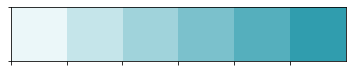

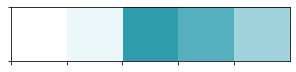

In [56]:
#pal = sns.cubehelix_palette(16, rot=0.4) #cubehelix_palette
pal=sns.light_palette((210, 90, 60), input="husl")
sns.palplot(pal)
kkcolors = ['white'] + [pal[i] for i in [0, 5,4, 2]]
sns.palplot(kkcolors)

In [57]:
# Functions
labels_order = ['noNN_RI', 'noNN_HMu', 'noNN_CwN', 'noNN_No', 'noNN_Rst', 'NN_RI',
                'NN_HMu', 'NN_CwN', 'NN_No']
pat = re.compile('.*/(exp\d)/(\w*)/nonn/freq([0-9\.]+)div(\w+)/(\w+)_\w+.csv')
decode_keys = ['experiment','function','freq','div','method']
nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq([0-9\.]+)\w+div([A-Za-z]+)/(\w+)_(\w+)_\w+.csv')
nn_decode_keys = ['experiment','function','freq','div','method','replace_mech']

def get_files(m): return list(path.glob(f'**/nonn/**/*{m}.csv'))
def get_nn_files(m): return list(path.glob(f'**/nn/**/*{m}.csv'))

def df_mean(df, m):
#     for n,d in df.groupby(['experiment', 'function', 'freq', 'method']):
#         import pdb;pdb.set_trace()
#     cols = df.columns[:100]
#     means = df.loc[:,cols].mean(axis=1)
#     df[m] = means
#     df.rename({'0': m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df#.drop(cols, axis=1)

def read_csv(f,m):
    df = pd.read_csv(f)
    for k,v in zip(decode_keys,pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['div']
    df['method'] = df['method'].str.replace('noNNRestart_No', 'noNN_Rst')
    df.drop('div', axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def read_nn_csv(f,m):
    df = pd.read_csv(f)
    for k,v in zip(nn_decode_keys,nn_pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    #df['method'] = df['method'] + '_' + df['replace_mech']
    df['method'] = df['method'] + '_' + df['replace_mech'] + '_' + df['div']
    df['method'] = df['method'].str.replace('NNnorm_Worst', 'NN')
    df.drop('replace_mech', axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def get_data(m='fitness', normalize=False):
#     short_dict = {'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNN_R':'noNN', 'noNN_RI': 'noNN_RI', 
#                   'noNN_CwN':'noNN_CwN','noNN_No':'noNN_No', 'noNNReval_arr.csv':'noNN', 'noNNReval_mof.csv':'noNN',  'NN_RI': 'NN_RI',  'NN_CwN': 'NN_CwN', 'NN_No':'NN_No', 'noNNRestart_No':'noNN_Rst', 'noNN_HMu':'noNN_HMu', 'NN_HMu':'NN_HMu'}
    files = get_files(m)
    nn_files = get_nn_files(m)
    data = pd.concat([read_csv(f,m) for f in files] + [read_nn_csv(f,m) for f in nn_files])
#     data.method = data.method.apply(lambda x: short_dict[x])
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data.reset_index(drop=True)

path = Path(f'../../data/cluster_results')
measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=0
m = measure_name[index_measure]
df = get_data(m)

def get_kk_data(m, freq):
    df = get_data(m).query(f'freq == {freq}')
    labels = df['method'].unique()
    labels = labels_order
    pcs = {}
    for exp,df_exp in df.groupby('experiment'):
        pcs[exp] = {}
        for fun,df_fun in df_exp.groupby('function'):
            values = [df_fun.query(f'method=={m!r}').mof for m in labels]
            x = np.array(values)
            stat,p = kruskal(*values)
            pc = sp.posthoc_conover(x, p_adjust='holm', val_col='values', group_col='groups')
            pc.columns = labels
            pc.index = labels
            pcs[exp][fun] = pc

    return pcs,labels

def plot_heatmap(pc):
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    ax,cbar = sp.sign_plot(pc, **heatmap_args)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_yticklabels(labels, rotation='horizontal')
    plt.tight_layout()

def plot_one(m, freq, legend=False):
    pcs,labels = get_kk_data(m, freq)
    fig,all_axs = plt.subplots(3, 4, figsize=(7,6))#, sharex=True, sharey=True)#10,14, #7,6

    for i,exp in enumerate(['exp1','exp2','exp3','exp4']):
        exp_pc = pcs[exp]
        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True,
                        'cbar_ax_bbox': [0.92, 0.57, 0.04, 0.3]}#[1.0, 0.6, 0.04, 0.3]
        sp.sign_plot(exp_pc['sphere'], cmap=kkcolors, ax=all_axs[0][i], **heatmap_args)
#         sp.sign_plot(exp_pc['sphere'], ax=all_axs[0][i], **heatmap_args)
        sp.sign_plot(exp_pc['rosenbrock'], cmap=kkcolors, ax=all_axs[1][i], **heatmap_args)
        _,cbar = sp.sign_plot(exp_pc['rastrigin'], cmap=kkcolors, ax=all_axs[2][i], **heatmap_args)
        if legend==False: cbar.remove()

    columns = exp_pc['sphere'].columns.tolist()

    for i,ax in enumerate(all_axs[0]): ax.set_title(f'exp{i+1}')    
    for ax in all_axs.flatten():
        ax.set_xticks(np.arange(len(labels))+0.5)
        ax.set_xticklabels(labels)
        ax.set_yticks(np.arange(len(labels))+0.5)
        ax.set_yticklabels(labels)

    for ax in all_axs[:-1].flatten(): ax.set_xticks([])
    for axs in all_axs:
        for ax in axs[1:]: ax.set_yticks([])
        
    for ax,t in zip([o[0] for o in all_axs],['Sphere','Rosenbrock','Rastrigin']):
        ax.set_ylabel(t)
        
#     plt.tight_layout()
    return fig,all_axs

/Users/maryam/anaconda3/envs/denn/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



/Users/maryam/anaconda3/envs/denn/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



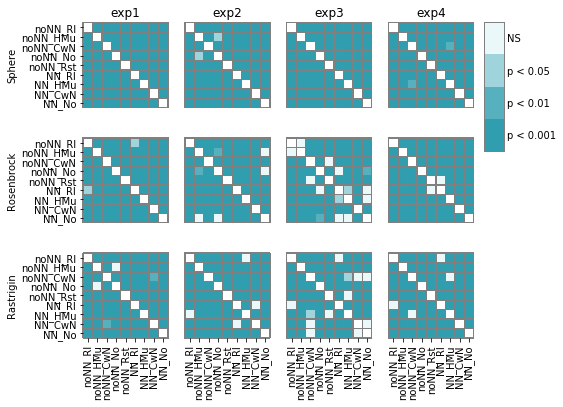

In [58]:
#for freq,legend in zip([0.5,1,4],[False,True,False]):
for freq,legend in zip([1],[True]):
    fig,ax = plot_one(m,freq,legend)
    plt.show()
    freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq
    fig.savefig(path/f'kruskal{freq_lbl}.eps', format='eps', dpi=1000, bbox_inches='tight')